# Laten factor models
<b> Latent factor models (LFMs)</b> belong to a group of unsupervised methods that model data in high-dimensional spaces using linear combinations of latent factors. This group of methods has been commonly used in the analysis of massive data sets due to its computational efficiency.

Modern recommender systems model data at multiple scales. We can distinguish for example between the "global", "regional" and "local" scales. Let's quickly analyse this view using an example of restaurants and a customer John.

At the <b>"global"</b> scale, one might want to analyse the overall mean rating of a restaurant or of the ratings submitted by John. This helps to capture the possible John's tendency to rate restaurants more strictly/leniently than other customers or to capture a general bias towards some restaurants belonging for example to one chain or type. To make a prediction of a rating, we could use a global mean rating and adjust it accordingly to John's biases.

At the <b>"local"</b> scale, we consider very detailed information about John or a specific restaurant group. This is often called a <b> collaborative filtering</b>. The model would then look at the similar (e.g. italian, fast-food etc.) restaurants that have been rated by John and try to predict the rating for another restaurant from the group. On the other hand, in order to predict John's rating of a specific restaurant from a group that John has never visited before, we might find users that rated other restaurants similarly to John and additionaly rated that restaurant we are interested in. Based on the ratings of others, we infere what would be the John's opinion here. 



# Restaurant rating prediction using Yelp dataset
The goal of this task is to recommend restaurants to users based on the rating data in the Yelp dataset. To do this, we will try to predict the rating a user will give to a restaurant that he has not been to yet based on a latent factor model.

![alt text](https://is1-ssl.mzstatic.com/image/thumb/Purple118/v4/63/d7/f9/63d7f93a-bc7d-1388-48ab-fa4016ed4830/AppIcon-1x_U007emarketing-0-0-GLES2_U002c0-512MB-sRGB-0-0-0-85-220-0-0-0-6.png/246x0w.jpg)<br>

In this notebook, we will use matrix factorization to build a model that is capable of reconstructing existing ratings and, as a "side-effect", predicting not existent ratings. The intuition for this task is the following. Based on the sparse data matrix [N,D] (a user rates just a tiny part of all restaurants from the dataset), we will construct two this dense matrices [N,k] and [k,D] that multiplied together, give us possibly the smallest reconstruction error. The largest advantage of this approach (matrix factorization) is that it allows us to use optimization methods like gradient descent or alternating optimization to find the most optimal solution. At the same time, we will be able to find predictions of any user/restaurant pair. This method let us capture the so called <b>"regional"</b> features. Depending on the latent dimensionality, the "regional" concepts will be more detail or rather wage. More on this topic can be found in the material about singular value decomposition. 




As mentioned above, we will use two optimization techniques: gradient descent and alternating optimization to compare the final reconstruction error and prediction accuracy as well as the computational effort.

Implementation based on the programming task in the course Mining Massive Datasets (Year: 2018) at the Technical University of Munich.

### 0. Libraries

We will be mostly using Numpy, SciPy.sparse and sklearn solvers for linear and ridge regression.

In [1]:
import scipy.sparse as sp
import numpy as np
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression, Ridge
import time

import pdb

## 1. Load data

Dataset is available on my GitHub: "ratings.npy"

In [2]:
ratings = np.load("ratings.npy")

In [3]:
# We have triplets of (user, restaurant, rating).
ratings

array([[101968,   1880,      1],
       [101968,    284,      5],
       [101968,   1378,      2],
       ...,
       [ 72452,   2100,      4],
       [ 72452,   2050,      5],
       [ 74861,   3979,      5]], dtype=uint32)

Now we transform the data into a matrix of dimension [N, D], where N is the number of users and D is the number of restaurants in the dataset.  
It is **strongly recommended** to load the data as a sparse matrix to **avoid out-of-memory issues**.

In [5]:
# Store the matrix into the variable M
M = sp.csr_matrix((ratings[:,2],(ratings[:,0],ratings[:,1])))

In [6]:
M

<337867x5899 sparse matrix of type '<class 'numpy.uint32'>'
	with 929606 stored elements in Compressed Sparse Row format>

## 2. Preprocess the data

In the preprocessing step, we recursively remove all users and restaurants with 10 or less ratings. Then, we randomly select 200 data points for the validation and test sets, respectively. After this, we subtract the mean rating for each users to account for this global effect. 

**Beware**: Some entries might become zero in this process -- but these entries are different than the 'unknown' zeros in the matrix. We will store the indices, of which we have data available, in a separate variable.

In [7]:
def cold_start_preprocessing(matrix, min_entries):
    """
    Recursively removes rows and columns from the input matrix which have less than min_entries nonzero entries.
    
    Parameters
    ----------
    matrix      : sp.spmatrix, shape [N, D]
                  The input matrix to be preprocessed.
    min_entries : int
                  Minimum number of nonzero elements per row and column.

    Returns
    -------
    matrix      : sp.spmatrix, shape [N', D']
                  The pre-processed matrix, where N' <= N and D' <= D
        
    """
    
    print("Shape before: {}".format(matrix.shape))

    # iterate until convergence
    break_crit = False
    while not break_crit:
        # computing masks for columns and rows to keep
        votes = matrix > 0
        mask_user = np.squeeze(np.array(votes.sum(1))) > min_entries
        mask_restaurants = np.squeeze(np.array(votes.sum(0))) > min_entries

        # removing columns/rows below threshold
        matrix = matrix[mask_user]
        matrix = matrix.T[mask_restaurants].T
        
        nnz = matrix>0
        break_crit = (nnz.sum(0).A1 > min_entries).all() and (nnz.sum(1).A1 > min_entries).all()
    
    print("Shape after: {}".format(matrix.shape))
    
    nnz = matrix>0
    
    assert (nnz.sum(0).A1 > min_entries).all()
    assert (nnz.sum(1).A1 > min_entries).all()
    return matrix

In [8]:
def shift_user_mean(matrix):
    """
    Subtract the mean rating per user from the non-zero elements in the input matrix.
    
    Parameters
    ----------
    matrix : sp.spmatrix, shape [N, D]
             Input sparse matrix.
    Returns
    -------
    matrix : sp.spmatrix, shape [N, D]
             The modified input matrix.
    
    user_means : np.array, shape [N, 1]
                 The mean rating per user that can be used to recover the absolute ratings from the mean-shifted ones.

    """
    
    mask = matrix != 0   # remember original zeros
    user_means = matrix.sum(1) / mask.sum(1)   # compute user_means
    matrix = sp.csr_matrix(mask.multiply(matrix - user_means))
    
    assert np.all(np.isclose(matrix.mean(1), 0))
    return matrix, user_means

In [9]:
def split_data(matrix, n_validation, n_test):
    """
    Extract validation and test entries from the input matrix. 
    
    Parameters
    ----------
    matrix          : sp.spmatrix, shape [N, D]
                      The input data matrix.
    n_validation    : int
                      The number of validation entries to extract.
    n_test          : int
                      The number of test entries to extract.

    Returns
    -------
    matrix_split    : sp.spmatrix, shape [N, D]
                      A copy of the input matrix in which the validation and test entries have been set to zero.
    
    val_idx         : tuple, shape [2, n_validation]
                      The indices of the validation entries.
    
    test_idx        : tuple, shape [2, n_test]
                      The indices of the test entries.
    
    val_values      : np.array, shape [n_validation, ]
                      The values of the input matrix at the validation indices.
                      
    test_values     : np.array, shape [n_test, ]
                      The values of the input matrix at the test indices.

    """
    
    # sample idx pairs from all non zero elements
    non_zero_elements = matrix.nonzero()
    samples_idx = np.random.choice(range(len(non_zero_elements[0])), n_validation + n_test)
    all_idx = np.zeros((2, n_validation + n_test))
    all_idx = np.array([non_zero_elements[0][samples_idx], non_zero_elements[1][samples_idx]])
    
    # split the randomly sampled idx pairs into test and validation and save the corresponding values
    val_idx = all_idx[:, :n_validation]
    test_idx = all_idx[:, n_validation:]
    val_values = np.squeeze(np.array(M[val_idx[0], val_idx[1]]))
    test_values = np.squeeze(np.array(M[test_idx[0], test_idx[1]]))
    
    # modify original matrix
    matrix_split = matrix.copy()
    matrix_split[all_idx[0], all_idx[1]] = 0
    matrix_split.eliminate_zeros()
    
    
    return matrix_split, val_idx, test_idx, val_values, test_values

In [10]:
M = cold_start_preprocessing(M, 10)

Shape before: (337867, 5899)
Shape after: (11275, 3531)


In [11]:
n_validation = 200
n_test = 200
# Split data
M_train, val_idx, test_idx, val_values, test_values = split_data(M, n_validation, n_test)

In [12]:
# Store away the nonzero indices of M before subtracting the row means.
nonzero_indices =  M.nonzero()

# Remove user means.
M_shifted, user_means = shift_user_mean(M_train)

# Apply the same shift to the validation and test data.
val_values_shifted = np.squeeze(np.array([val_values[i] - user_means[val_idx[0, i]] for i in range(n_validation)]))
test_values_shifted = np.squeeze(np.array([test_values[i] - user_means[test_idx[0, i]] for i in range(n_validation)]))

## 3. Alternating optimization

In the first step, we will approach the problem via alternating optimization. To initialize the two matrices P and Q, we will either use SVD or a random initialization. The approach is to update single vectors of Q (row vectors) and P (column vectors) iteratively. We will freeze Q and then find optimal column vectors in P and then do the same for Q, freezing P and repeat all until convergence.

In [13]:
def initialize_Q_P(matrix, k, init='random'):
    """
    Initialize the matrices Q and P for a latent factor model.
    
    Parameters
    ----------
    matrix : sp.spmatrix, shape [N, D]
             The matrix to be factorized.
    k      : int
             The number of latent dimensions.
    init   : str in ['svd', 'random'], default: 'random'
             The initialization strategy. 'svd' means that we use SVD to initialize P and Q, 'random' means we initialize
             the entries in P and Q randomly in the interval [0, 1).

    Returns
    -------
    Q : np.array, shape [N, k]
        The initialized matrix Q of a latent factor model.

    P : np.array, shape [k, D]
        The initialized matrix P of a latent factor model.
    """

    N, D = matrix.shape
    if init == 'svd':
        Q, _, P = svds(matrix, k=k) # Error: Q should a product of the original matrices Q and Sigma!!!!
    elif init == 'random':
        Q, P = np.random.uniform(size=(N, k)), np.random.uniform(size=(k, D))
    else:
        raise ValueError
        
    assert Q.shape == (matrix.shape[0], k)
    assert P.shape == (k, matrix.shape[1])
    return Q, P

In [14]:
def latent_factor_alternating_optimization(M, non_zero_idx, k, val_idx, val_values,
                                           reg_lambda, max_steps=100, init='random',
                                           log_every=1, patience=10, eval_every=1):
    """
    Perform matrix factorization using alternating optimization. Training is done via patience,
    i.e. we stop training after we observe no improvement on the validation loss for a certain
    amount of training steps. We then return the best values for Q and P oberved during training.
    
    Parameters
    ----------
    M                 : sp.spmatrix, shape [N, D]
                        The input matrix to be factorized.
                      
    non_zero_idx      : np.array, shape [nnz, 2]
                        The indices of the non-zero entries of the un-shifted matrix to be factorized. 
                        nnz refers to the number of non-zero entries. Note that this may be different
                        from the number of non-zero entries in the input matrix M, e.g. in the case
                        that all ratings by a user have the same value.
    
    k                 : int
                        The latent factor dimension.
    
    val_idx           : tuple, shape [2, n_validation]
                        Tuple of the validation set indices.
                        n_validation refers to the size of the validation set.
                      
    val_values        : np.array, shape [n_validation, ]
                        The values in the validation set.
                      
    reg_lambda        : float
                        The regularization strength.
                      
    max_steps         : int, optional, default: 100
                        Maximum number of training steps. Note that we will stop early if we observe
                        no improvement on the validation error for a specified number of steps
                        (see "patience" for details).
                      
    init              : str in ['random', 'svd'], default 'random'
                        The initialization strategy for P and Q. See function initialize_Q_P for details.
    
    log_every         : int, optional, default: 1
                        Log the training status every X iterations.
                    
    patience          : int, optional, default: 10
                        Stop training after we observe no improvement of the validation loss for X evaluation
                        iterations (see eval_every for details). After we stop training, we restore the best 
                        observed values for Q and P (based on the validation loss) and return them.
                      
    eval_every        : int, optional, default: 1
                        Evaluate the training and validation loss every X steps. If we observe no improvement
                        of the validation error, we decrease our patience by 1, else we reset it to *patience*.

    Returns
    -------
    best_Q            : np.array, shape [N, k]
                        Best value for Q (based on validation loss) observed during training
                      
    best_P            : np.array, shape [k, D]
                        Best value for P (based on validation loss) observed during training
                      
    validation_losses : list of floats
                        Validation loss for every evaluation iteration, can be used for plotting the validation
                        loss over time.
                        
    train_losses      : list of floats
                        Training loss for every evaluation iteration, can be used for plotting the training
                        loss over time.                     
    
    converged_after   : int
                        it - patience*eval_every, where it is the iteration in which patience hits 0,
                        or -1 if we hit max_steps before converging. 

    """

    best_Q, best_P = None, None
    best_val_loss = np.infty
    train_losses, validation_losses = [], []
    
    # initialize P & Q
    Q, P = initialize_Q_P(M, k, init=init)
    
    # iterate/train until no_improvement_counter > patience or reached max_steps
    no_improvement_counter = 0
    step = 0
    while step <= max_steps:
    
        # check whether it is time for evaluation
        if step % eval_every == 0:

            # compute training and validation loss
            M_estimate = Q.dot(P)
            train_diff = M[M.nonzero()] - M_estimate[M.nonzero()]
            train_loss = train_diff * train_diff.T
            train_losses.append(train_loss[0,0])
            validation_diff = val_values - M_estimate[val_idx[0], val_idx[1]]
            validation_loss = validation_diff.dot(validation_diff)
            validation_losses.append(validation_loss)
            
            print('Iteration ' + str(step) + ', training loss: ' + str(round(train_loss[0,0], 2)) + 
              ', validation loss: ' + str(round(validation_loss, 2)))
            
            # if current Q, P best factors save them
            if best_val_loss > validation_loss:
                best_Q, best_P = Q.copy(), P.copy()
                best_val_loss = validation_loss
                no_improvement_counter = 0
            else: 
                no_improvement_counter += 1
                if no_improvement_counter >= patience:
                    break
        
        # update P
        for i in range(P.shape[1]):

            # initialize regressor
            clf = Ridge(alpha=reg_lambda)

            # determine matrix X and target y for regression problem
            idx = non_zero_idx[0][non_zero_idx[1] == i]
            X = Q[idx, :]
            y = np.squeeze(np.array(M[idx, i].todense()))

            # fit and store results in P
            ridge = clf.fit(X,y)
            P[:, i] = ridge.coef_
        
        # update Q
        for i in range(Q.shape[0]):

            # initialize regressor
            clf = Ridge(alpha=reg_lambda)

            # determine matrix X and target y for regression problem
            idx = non_zero_idx[1][non_zero_idx[0] == i]
            X = P[:, idx]
            y = np.squeeze(np.array(M[i, idx].todense()))

            # fit and store results in Q
            ridge = clf.fit(X.T,y)
            Q[i, :] = ridge.coef_
        
        step += 1
    
    converged_after = -1 if step > max_steps else step - patience
    
    print('Converged after ' + str(converged_after) + ' iterations.')
    
    return best_Q, best_P, validation_losses, train_losses, converged_after


### Training the latent factor model with alternating optimization.

We will learn the optimal $P$ and $Q$ using alternating optimization. That is, during each iteration, we first update $Q$ while having $P$ fixed and then vice versa. We will run the alternating optimization algorithm with $k=100$ and $\lambda=1$ and plot the training and validation losses over time.

In [15]:
Q_a, P_a, val_l_a, tr_l_a, conv_a = latent_factor_alternating_optimization(M_shifted, nonzero_indices, 
                                                                           k=100, val_idx=val_idx,
                                                                           val_values=val_values_shifted, 
                                                                           reg_lambda=1, init='random',
                                                                           max_steps=100, patience=10)

Iteration 0, training loss: 174880750.08, validation loss: 125072.2
Iteration 1, training loss: 31169.96, validation loss: 253.12
Iteration 2, training loss: 11058.15, validation loss: 250.87
Iteration 3, training loss: 8104.53, validation loss: 251.93
Iteration 4, training loss: 7111.16, validation loss: 251.96
Iteration 5, training loss: 6636.5, validation loss: 251.52
Iteration 6, training loss: 6361.16, validation loss: 250.84
Iteration 7, training loss: 6183.49, validation loss: 250.15
Iteration 8, training loss: 6061.31, validation loss: 249.59
Iteration 9, training loss: 5973.1, validation loss: 249.21
Iteration 10, training loss: 5906.3, validation loss: 249.0
Iteration 11, training loss: 5853.29, validation loss: 248.96
Iteration 12, training loss: 5809.5, validation loss: 249.02
Iteration 13, training loss: 5772.2, validation loss: 249.13
Iteration 14, training loss: 5739.65, validation loss: 249.27
Iteration 15, training loss: 5710.67, validation loss: 249.41
Iteration 16, t

### Plot of the validation and training losses over training time

**Note** that after few iteration, the validation loss increases! Early stopping is the way to go against the overfitting to the training data!

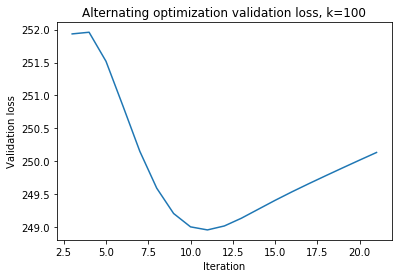

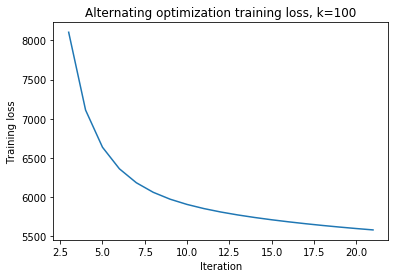

In [16]:
fig = plt.figure()
x = range(len(val_l_a))
plt.plot(x[3:], val_l_a[3:])
plt.title('Alternating optimization validation loss, k=100')
plt.xlabel('Iteration')
plt.ylabel('Validation loss')

fig = plt.figure()
x = range(len(tr_l_a))
plt.plot(x[3:], tr_l_a[3:])
plt.title('Alternating optimization training loss, k=100')
plt.xlabel('Iteration')
plt.ylabel('Training loss')

plt.show()

#### We will try some different latent dimensions $k$. 

In [20]:
Q_a_2, P_a_2, val_l_a_2, tr_l_a_2, conv_a_2 = latent_factor_alternating_optimization(M_shifted, nonzero_indices, 
                                                                           k=20, val_idx=val_idx,
                                                                           val_values=val_values_shifted, 
                                                                           reg_lambda=0.1, init='random',
                                                                           max_steps=100, patience=10)

Iteration 0, training loss: 7765068.645, validation loss: 5523.554
Iteration 1, training loss: 106867.510, validation loss: 705.126
Iteration 2, training loss: 82654.821, validation loss: 613.702
Iteration 3, training loss: 70874.674, validation loss: 647.832
Iteration 4, training loss: 63519.477, validation loss: 693.470
Iteration 5, training loss: 58398.719, validation loss: 708.338
Iteration 6, training loss: 54585.352, validation loss: 708.316
Iteration 7, training loss: 51609.199, validation loss: 704.384
Iteration 8, training loss: 49207.058, validation loss: 700.860
Iteration 9, training loss: 47218.316, validation loss: 697.695
Iteration 10, training loss: 45542.649, validation loss: 694.655
Iteration 11, training loss: 44112.976, validation loss: 691.743
Converged after 2 iterations, on average 14.411 per iteration


#### ... and plot the validation and training losses over training time

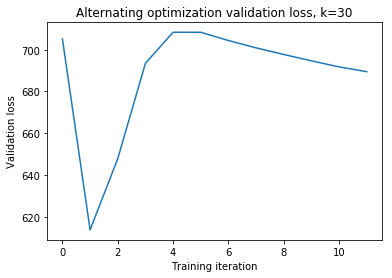

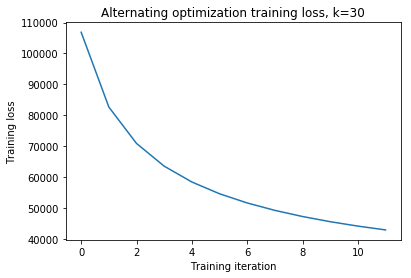

In [25]:
fig = plt.figure()
x = range(len(val_l_a))
plt.plot(x[3:], val_l_a[3:])
plt.title('Alternating optimization validation loss, k=20')
plt.xlabel('Iteration')
plt.ylabel('Validation loss')

fig = plt.figure()
x = range(len(tr_l_a))
plt.plot(x[3:], tr_l_a[3:])
plt.title('Alternating optimization training loss, k=20')
plt.xlabel('Iteration')
plt.ylabel('Training loss')

plt.show()

## 4. Latent factorization using gradient descent

We now use gradient descent to factorize our ratings matrix. We will try both (mini-) batch and stochastic gradient descent.

Recall that the objective function (loss) we wanted to optimize was:
$$
\mathcal{L} = \min_{P, Q} \sum_{(x, i) \in W} (r_{xi} - \mathbf{q}_i^T\mathbf{p}_x)^2 + \lambda_1\sum_x{\left\lVert \mathbf{p}_x  \right\rVert}^2 + \lambda_2\sum_i {\left\lVert\mathbf{q}_i  \right\rVert}^2
$$

where $W$ is the set of $(x, i)$ pairs for which $r_{xi}$ is known (in this case our known play counts). Here we have also introduced two regularization terms to help us with overfitting where $\lambda_1$ and $\lambda_2$ are hyper-parameters that control the strength of the regularization.

Naturally optimizing with gradient descent involves computing the gradient of the loss function $\mathcal{L}$ w.r.t. to the parameters. To help you solve the task we provide the following:

$$
\frac{\partial ((r_{xi} - \mathbf{q}_i^T\mathbf{p}_x)^2)}{\partial \mathbf{p}_x} = -2(r_{xi} - \mathbf{q}_i^T\mathbf{p}_x)\mathbf{q}_i\;, ~~~
\frac{\partial ((r_{xi} - \mathbf{q}_i^T\mathbf{p}_x)^2)}{\partial \mathbf{q}_i} = -2(r_{xi} - \mathbf{q}_i^T\mathbf{p}_x)\mathbf{p}_x 
$$

$$
\frac{\partial(\lambda_1{\left\lVert \mathbf{p}_x \right\rVert}^2)}{\partial \mathbf{p}_x} = 2 \lambda_1 \mathbf{p_x} \;, ~~~
\frac{\partial(\lambda_2{\left\lVert \mathbf{q}_i \right\rVert}^2)}{\partial \mathbf{q}_i} = 2 \lambda_2 \mathbf{q_i}
$$

**!!!**: We have to carefully consider how to combine the given partial gradients depending
on which variants of gradient descent you are using.  
**!!!**: It may be useful to scale the updates to $P$ and $Q$ by $\frac{1}{batch\_size}$ (in the case of full-sweep updates, this would be $\frac{1}{n\_users}$ for $Q$ and $\frac{1}{n\_restaurants}$ for $P$).


For each of the gradients descent variants, we report and compare the following:
* How many iterations do you need for convergence.
* Plot the loss (y axis) for each iteration (x axis).


In [17]:
def latent_factor_gradient_descent(M, non_zero_idx, k, val_idx, val_values, 
                                   reg_lambda, learning_rate, batch_size=-1,
                                   max_steps=50000, init='random',
                                   log_every=1000, patience=20,
                                   eval_every=50):
    """
    Perform matrix factorization using gradient descent. Training is done via patience,
    i.e. we stop training after we observe no improvement on the validation loss for a certain
    amount of training steps. We then return the best values for Q and P oberved during training.
    
    Parameters
    ----------
    M                 : sp.spmatrix, shape [N, D]
                        The input matrix to be factorized.
                      
    non_zero_idx      : np.array, shape [nnz, 2]
                        The indices of the non-zero entries of the un-shifted matrix to be factorized. 
                        nnz refers to the number of non-zero entries. Note that this may be different
                        from the number of non-zero entries in the input matrix M, e.g. in the case
                        that all ratings by a user have the same value.
    
    k                 : int
                        The latent factor dimension.
    
    val_idx           : tuple, shape [2, n_validation]
                        Tuple of the validation set indices.
                        n_validation refers to the size of the validation set.
                      
    val_values        : np.array, shape [n_validation, ]
                        The values in the validation set.
                      
    reg_lambda        : float
                        The regularization strength.

    learning_rate     : float
                        Step size of the gradient descent updates.
                        
    batch_size        : int, optional, default: -1
                        (Mini-) batch size. -1 means we perform standard full-sweep gradient descent.
                        If the batch size is >0, use mini batches of this given size.
                        
    max_steps         : int, optional, default: 100
                        Maximum number of training steps. Note that we will stop early if we observe
                        no improvement on the validation error for a specified number of steps
                        (see "patience" for details).
                      
    init              : str in ['random', 'svd'], default 'random'
                        The initialization strategy for P and Q. See function initialize_Q_P for details.
    
    log_every         : int, optional, default: 1
                        Log the training status every X iterations.
                    
    patience          : int, optional, default: 10
                        Stop training after we observe no improvement of the validation loss for X evaluation
                        iterations (see eval_every for details). After we stop training, we restore the best 
                        observed values for Q and P (based on the validation loss) and return them.
                      
    eval_every        : int, optional, default: 1
                        Evaluate the training and validation loss every X steps. If we observe no improvement
                        of the validation error, we decrease our patience by 1, else we reset it to *patience*.
                        
    Returns
    -------
    best_Q            : np.array, shape [N, k]
                        Best value for Q (based on validation loss) observed during training
                      
    best_P            : np.array, shape [k, D]
                        Best value for P (based on validation loss) observed during training
                      
    validation_losses : list of floats
                        Validation loss for every evaluation iteration, can be used for plotting the validation
                        loss over time.
                        
    train_losses      : list of floats
                        Training loss for every evaluation iteration, can be used for plotting the training
                        loss over time.                     
    
    converged_after   : int
                        it - patience*eval_every, where it is the iteration in which patience hits 0,
                        or -1 if we hit max_steps before converging. 

    """
       
    N, D = M.shape
    best_Q, best_P = None, None
    best_val_loss = np.infty
    train_losses, validation_losses = [], []
    
    # initialize P & Q
    Q, P = initialize_Q_P(M, k, init=init)
    
    # iterate/train until no_improvement_counter > patience or reached max_steps
    no_improvement_counter = 0
    step = 0
    
    if batch_size == -1:
        batch = non_zero_idx
        unique_x = np.unique(batch[1])
        unique_i = np.unique(batch[0])
    
    while step <= max_steps:
    
        # check whether it is time for evaluation or logging
        if step % eval_every == 0 or step % log_every == 0:

            # compute training and validation loss
            M_estimate = Q.dot(P)
            train_diff = M[M.nonzero()] - M_estimate[M.nonzero()]
            train_loss = train_diff * train_diff.T
            train_losses.append(train_loss[0,0])
            validation_diff = val_values - M_estimate[val_idx[0], val_idx[1]]
            validation_loss = validation_diff.dot(validation_diff)
            validation_losses.append(validation_loss)
            
            # if logging time, log
            if step % log_every == 0:
                print('Iteration ' + str(step) + ', training loss: ' + str(round(train_loss[0,0], 3)) + 
                  ', validation loss: ' + str(round(validation_loss, 3)))

            # if evaluation time compare result
            if step % eval_every == 0:
                # if current Q, P best factors save them
                if best_val_loss > validation_loss:
                    best_Q, best_P = Q.copy(), P.copy()
                    best_val_loss = validation_loss
                    no_improvement_counter = 0
                else: 
                    no_improvement_counter += 1
                    if no_improvement_counter >= patience:
                        break
        
        # if not working on full sweep update draw batch randomly from training samples
        if batch_size != -1:
            idxs = np.random.choice(range(non_zero_idx[0].size), batch_size, replace=False)
            batch = (non_zero_idx[0][idxs], non_zero_idx[1][idxs])
            unique_x = np.unique(batch[1])
            unique_i = np.unique(batch[0])
        
        # mini batch or 
        dL_dP = np.zeros(P.shape)
        dL_dQ = np.zeros(Q.shape)
        
        # compute grad p
        for x in unique_x:
            i_s = non_zero_idx[0][non_zero_idx[1] == x]
            q_is, p_x = Q[i_s, :], P[:, x]
            
            # apply formula for grad p
            r_xi = np.squeeze(np.array(M[i_s, x].todense()))
            reg_term = 2 * reg_lambda * p_x
            err_term = -2 * (r_xi - q_is.dot(p_x)).dot(q_is)
            
            dL_dP[:, x] += err_term + reg_term
        
        # compute grad q
        for i in unique_i:
            x_s = non_zero_idx[1][non_zero_idx[0] == i]
            q_i, p_xs = Q[i, :], P[:, x_s]
            
            # apply formula for grad q
            r_xi = np.squeeze(np.array(M[i, x_s].todense()))
            reg_term = 2 * reg_lambda * q_i
            err_term = -2 * p_xs.dot(r_xi - q_i.dot(p_xs))
            
            dL_dQ[i, :] += err_term + reg_term

        if batch_size == -1:
            P -= learning_rate * dL_dP * D / batch[0].size
            Q -= learning_rate * dL_dQ * N / batch[0].size
        else:
            P -= learning_rate * dL_dP / batch_size
            Q -= learning_rate * dL_dQ / batch_size
        
        step += 1
    
    converged_after = -1 if step > max_steps else step - patience
    
    print('Converged after ' + str(converged_after) + ' iterations.')
            
    return best_Q, best_P, validation_losses, train_losses, converged_after

#### Train the latent factor model with standard gradient descent.

1. We learn the optimal $P$ and $Q$ using standard gradient descent. That is, during each iteration we have to use all of the training examples and update $Q$ and $P$ for all users and songs at once. We try the algorithm with $k=30$, $\lambda=1$, and learning rate of 0.1 and initialize $Q$ and $P$ with SVD.  

In [108]:
#For fast execution we set max_steps = 10, log_every = 2, eval_every = 2
#The graph below has been plotted for the initial parameters
Q_g_sweep, P_g_sweep, val_l_g_sweep, tr_l_g_sweep, conv_g_sweep =  latent_factor_gradient_descent(M_shifted, nonzero_indices, 
                                                                                                   k=30, val_idx=val_idx,
                                                                                                   val_values=val_values_shifted, 
                                                                                                   reg_lambda=1, learning_rate=1e-1,
                                                                                                   init='svd', batch_size=-1,
                                                                                                   max_steps=10, log_every=2, 
                                                                                                   eval_every=2)

Iteration 0, training loss: 335283.27, validation loss: 248.28
Iteration 2, training loss: 334053.609, validation loss: 248.199
Iteration 4, training loss: 332194.025, validation loss: 248.056
Iteration 6, training loss: 329397.408, validation loss: 247.807
Iteration 8, training loss: 325355.378, validation loss: 247.405
Iteration 10, training loss: 319908.842, validation loss: 246.851
Converged after -1 iterations.


#### Plot the validation and training losses over training time

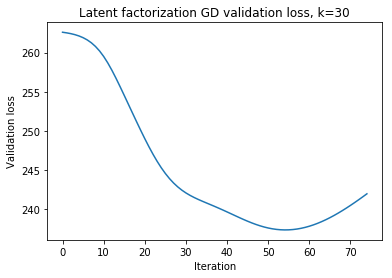

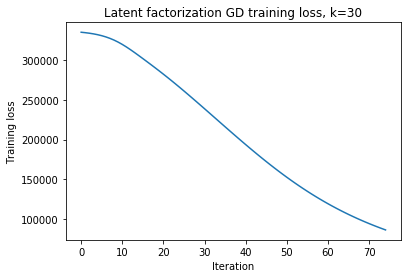

In [86]:
fig = plt.figure()
x = range(len(val_l_g_sweep))
plt.plot(x, val_l_g_sweep)
plt.title('Latent factorization GD validation loss, k=30')
plt.xlabel('Iteration')
plt.ylabel('Validation loss')

fig = plt.figure()
plt.plot(x, tr_l_g_sweep)
plt.title('Latent factorization GD training loss, k=30')
plt.xlabel('Iteration')
plt.ylabel('Training loss')

plt.show()

We learn the optimal $P$ and $Q$ using the original stochastic gradient descent (mini-batches of size 1). That is, during each iteration you sample a single random training example $r_{xi}$ and update only the respective affected parameters $\mathbf{p_x}$ and $\mathbf{q}_i$. Set the learning rate to 0.01 and keep the other parameters as in a).

In [85]:
Q_g_st, P_g_st, val_l_g_st, tr_l_g_st, conv_g_st = latent_factor_gradient_descent(M_shifted, nonzero_indices, 
                                                                                   k=30, val_idx=val_idx,
                                                                                   val_values=val_values_shifted, 
                                                                                   reg_lambda=1, learning_rate=1e-2,
                                                                                   init='svd', batch_size=1,
                                                                                   max_steps=20000, log_every=500, 
                                                                                   eval_every=50)

Iteration 0, training loss: 335305.482, validation loss: 262.599
Iteration 500, training loss: 333682.765, validation loss: 262.43
Iteration 1000, training loss: 332046.225, validation loss: 262.224
Iteration 1500, training loss: 330111.354, validation loss: 261.893
Iteration 2000, training loss: 328055.591, validation loss: 261.487
Iteration 2500, training loss: 326091.7, validation loss: 260.354
Iteration 3000, training loss: 323705.326, validation loss: 259.532
Iteration 3500, training loss: 321770.085, validation loss: 259.269
Iteration 4000, training loss: 319938.101, validation loss: 259.263
Iteration 4500, training loss: 318053.177, validation loss: 259.356
Converged after 4530 iterations.


#### Plot the validation and training losses over (training) time

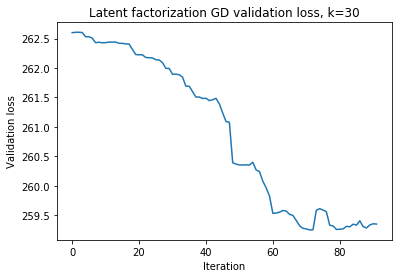

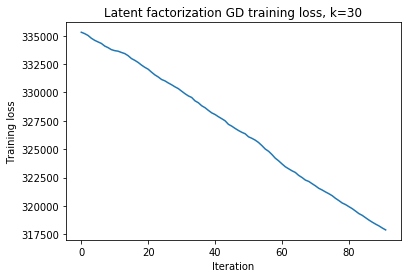

In [87]:
fig = plt.figure()
x = range(len(val_l_g_st))
plt.plot(x, val_l_g_st)
plt.title('Latent factorization GD validation loss, k=30')
plt.xlabel('Iteration')
plt.ylabel('Validation loss')

fig = plt.figure()
plt.plot(x, tr_l_g_st)
plt.title('Latent factorization GD training loss, k=30')
plt.xlabel('Iteration')
plt.ylabel('Training loss')

plt.show()

We now learn the optimal $P$ and $Q$ this time using larger mini-batches of size 32.

In [88]:
Q_g_mb, P_g_mb, val_l_g_mb, tr_l_g_mb, conv_g_mb = latent_factor_gradient_descent(M_shifted, nonzero_indices, 
                                                                                   k=30, val_idx=val_idx,
                                                                                   val_values=val_values_shifted, 
                                                                                   reg_lambda=1, learning_rate=1e-1,
                                                                                   init='svd', batch_size=32,
                                                                                   max_steps=10000, log_every=100, 
                                                                                   eval_every=50)

Iteration 0, training loss: 335305.482, validation loss: 262.599
Iteration 100, training loss: 332086.989, validation loss: 262.181
Iteration 200, training loss: 327774.205, validation loss: 261.243
Iteration 300, training loss: 323153.364, validation loss: 260.185
Iteration 400, training loss: 318652.913, validation loss: 259.217
Iteration 500, training loss: 314530.546, validation loss: 258.293
Iteration 600, training loss: 310739.028, validation loss: 257.527
Iteration 700, training loss: 306968.013, validation loss: 256.693
Iteration 800, training loss: 303289.934, validation loss: 256.313
Iteration 900, training loss: 299458.264, validation loss: 255.955
Iteration 1000, training loss: 295669.664, validation loss: 255.412
Iteration 1100, training loss: 291835.248, validation loss: 255.11
Iteration 1200, training loss: 288040.103, validation loss: 255.036
Iteration 1300, training loss: 284253.136, validation loss: 255.27
Iteration 1400, training loss: 280325.229, validation loss: 25

#### Plot the validation and training losses over (training) time

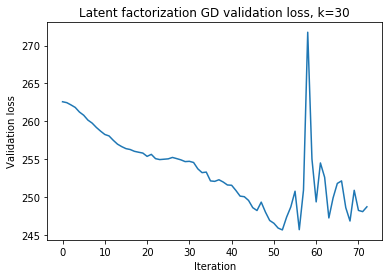

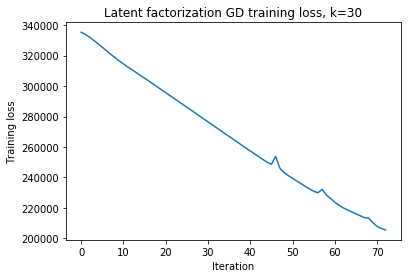

In [89]:
fig = plt.figure()
x = range(len(val_l_g_mb))
plt.plot(x, val_l_g_mb)
plt.title('Latent factorization GD validation loss, k=30')
plt.xlabel('Iteration')
plt.ylabel('Validation loss')

fig = plt.figure()
plt.plot(x, tr_l_g_mb)
plt.title('Latent factorization GD training loss, k=30')
plt.xlabel('Iteration')
plt.ylabel('Training loss')

plt.show()

## 4.5 Hyperparameter search

Machine learning models are often heavily dependent on the hyperparameter settings, e.g. the learning rate. Here, we will try a simple random search to find good values of the latent factor dimension $k$, the batch size, learning rate, and regularization.  


We will perform a hyperparameter search to find good values for the batch size, lambda, learning rate, and latent dimension. 

* For the batch size, we evaluate all values in [1, 32, 512, -1] (-1 corresponds to full-sweep gradient descent).
* For $\lambda$, randomly sample three values in the interval [0, 1).
* For the learning rate, evaluate all values in [1, 0.1, 0.01].
* For the latent dimension, uniformly sample three values in the interval [5,30].

We perform an exhaustive search among all combinations of these values.

**!!!**: This may take a while to compute. We use "dummy" code instead of actual model training. (You can let it train, e.g., for only one iteration if you don't want to wait). 

In [32]:
def parameter_search(M_train, val_idx, val_values):
    """
    Hyperparameter search using random search.
    
    Parameters
    ----------
    
    M_train     : sp.spmatrix, shape [N, D]
                  Input sparse matrix where the user means have not
                  been subtracted yet. 
                  
    val_idx     : tuple, shape [2, n_validation]
                  The indices used for validation, where n_validation
                  is the size of the validation set.
                  
    val_values  : np.array, shape [n_validation, ]
                  Validation set values, where n_validation is the
                  size of the validation set.

    Returns
    -------
    best_conf   : tuple, (batch_size, lambda, learning_rate, latent_dimension)
                  The best-performing hyperparameters.
                  

    """
    
    # initialize parameter lists
    batch_sizes = [1, 32, 512,-1]
    lambdas = np.random.random(3)
    learning_rates = [1, 0.1, 0.01] 
    latent_dimensions = np.round(25 * np.random.random(3) + 5).astype(np.int)
    
    # container for optimal val performance and configuration
    best_conf = None
    best_val = np.infty
    
    # loop over values
    for bs in batch_sizes:
        for ld in lambdas:
            for lr in learning_rates:
                for k in latent_dimensions:
                    current_conf = (bs, ld, lr, k)
                    print('Training configuration ' + str(current_conf) + '.....')
                    #For fast execution we set max_steps = 1, log_every = 1, eval_every = 1
                    Q_g, P_g, val_l_g, tr_l_g, conv_g = latent_factor_gradient_descent(M_shifted, nonzero_indices, 
                                                                                   k=k, val_idx=val_idx,
                                                                                   val_values=val_values_shifted, 
                                                                                   reg_lambda=ld, learning_rate=lr,
                                                                                   init='svd', batch_size=bs,
                                                                                   max_steps=1, log_every=1, 
                                                                                   eval_every=1)
                    
                    optimum = np.min(val_l_g)
                    print('Done. Best validation loss ' + str(optimum))
                    if optimum < best_val:
                        best_conf = current_conf
                        best_val = optimum
                        print('New best configuration: ' + str(current_conf))
                    print('------------------------------')
        
    print("Best configuration is: "+str(best_conf))
    return best_conf
    

In [33]:
best_configuration = parameter_search(M_train, val_idx, val_values)

Training configuration (1, 0.13131431612601308, 1, 25).....
Iteration 0, training loss: 335540.788, validation loss: 248.305
Iteration 1, training loss: 335537.452, validation loss: 248.305
Converged after -1 iterations.
Done. Best validation loss 248.3048742332842
New best configuration: (1, 0.13131431612601308, 1, 25)
------------------------------
Training configuration (1, 0.13131431612601308, 1, 17).....
Iteration 0, training loss: 335971.168, validation loss: 248.315
Iteration 1, training loss: 335962.174, validation loss: 248.315
Converged after -1 iterations.
Done. Best validation loss 248.31541777272264
------------------------------
Training configuration (1, 0.13131431612601308, 1, 23).....
Iteration 0, training loss: 335645.675, validation loss: 248.308
Iteration 1, training loss: 336146.359, validation loss: 248.308
Converged after -1 iterations.
Done. Best validation loss 248.30756318087313
------------------------------
Training configuration (1, 0.13131431612601308, 0.1

Iteration 0, training loss: 335540.788, validation loss: 248.305
Iteration 1, training loss: 335287.036, validation loss: 248.304
Converged after -1 iterations.
Done. Best validation loss 248.30386499104904
------------------------------
Training configuration (32, 0.13131431612601308, 1, 17).....
Iteration 0, training loss: 335971.168, validation loss: 248.315
Iteration 1, training loss: 335623.286, validation loss: 248.305
Converged after -1 iterations.
Done. Best validation loss 248.30500416234136
------------------------------
Training configuration (32, 0.13131431612601308, 1, 23).....
Iteration 0, training loss: 335645.675, validation loss: 248.308
Iteration 1, training loss: 335548.179, validation loss: 248.307
Converged after -1 iterations.
Done. Best validation loss 248.3071621312745
------------------------------
Training configuration (32, 0.13131431612601308, 0.1, 25).....
Iteration 0, training loss: 335540.788, validation loss: 248.305
Iteration 1, training loss: 335517.70

Iteration 1, training loss: 335392.823, validation loss: 248.287
Converged after -1 iterations.
Done. Best validation loss 248.28655501332946
------------------------------
Training configuration (512, 0.13131431612601308, 1, 17).....
Iteration 0, training loss: 335971.168, validation loss: 248.315
Iteration 1, training loss: 335853.547, validation loss: 248.311
Converged after -1 iterations.
Done. Best validation loss 248.31053857479418
------------------------------
Training configuration (512, 0.13131431612601308, 1, 23).....
Iteration 0, training loss: 335645.675, validation loss: 248.308
Iteration 1, training loss: 335497.901, validation loss: 248.299
Converged after -1 iterations.
Done. Best validation loss 248.29866994937277
------------------------------
Training configuration (512, 0.13131431612601308, 0.1, 25).....
Iteration 0, training loss: 335540.788, validation loss: 248.305
Iteration 1, training loss: 335526.324, validation loss: 248.305
Converged after -1 iterations.
Do

Iteration 0, training loss: 335971.168, validation loss: 248.315
Iteration 1, training loss: 330538.428, validation loss: 247.888
Converged after -1 iterations.
Done. Best validation loss 247.88816370567682
------------------------------
Training configuration (-1, 0.13131431612601308, 1, 23).....
Iteration 0, training loss: 335645.675, validation loss: 248.308
Iteration 1, training loss: 328933.464, validation loss: 247.887
Converged after -1 iterations.
Done. Best validation loss 247.8869694095964
------------------------------
Training configuration (-1, 0.13131431612601308, 0.1, 25).....
Iteration 0, training loss: 335540.788, validation loss: 248.305
Iteration 1, training loss: 335039.949, validation loss: 248.276
Converged after -1 iterations.
Done. Best validation loss 248.27582823663803
------------------------------
Training configuration (-1, 0.13131431612601308, 0.1, 17).....
Iteration 0, training loss: 335971.168, validation loss: 248.315
Iteration 1, training loss: 335592.

#### Output the best hyperparameter optimization

In [34]:
print("Best batch size: ", best_configuration[0])
print("Best lambda: ", best_configuration[1] )
print("Best learning rate: ", best_configuration[2] )
print("Best latent dimension: ", best_configuration[3])

Best batch size:  -1
Best lambda:  0.13131431612601308
Best learning rate:  1
Best latent dimension:  25


In [36]:
#Find the optimal P and Q for gradient descent returned by hyperparameter optimization
#For fast execution we set max_steps = 5, log_every = 1, eval_every = 1
best_Q_gr, best_P_gr, val_l_gr, tr_l_gr, conv_gr = latent_factor_gradient_descent(M_shifted, nonzero_indices, 
                                                                                   k=best_configuration[3], val_idx=val_idx,
                                                                                   val_values=val_values_shifted, 
                                                                                   reg_lambda=best_configuration[1], learning_rate=best_configuration[2],
                                                                                   init='svd', batch_size=best_configuration[0],
                                                                                   max_steps=5, log_every=1, 
                                                                                   eval_every=1)

Iteration 0, training loss: 335540.788, validation loss: 248.305
Iteration 1, training loss: 328440.261, validation loss: 247.876
Iteration 2, training loss: 305760.911, validation loss: 246.783
Iteration 3, training loss: 279976.787, validation loss: 251.217
Iteration 4, training loss: 264902.744, validation loss: 257.435
Iteration 5, training loss: 1232262.262, validation loss: 11920.758
Converged after -1 iterations.


## 5. Comparison of gradient descent and alternating optimization

After training the latent factor model with both alternating optimization and gradient descent, we now compare their results on the training, validation, and test set.

In [38]:
# Comparison for the best gradient descent model
best_M_gr = best_Q_gr.dot(best_P_gr) + user_means
tuple_x = sp.find(M_train)

training_rmse_gr = np.sqrt((1/len(tuple_x[0])) * np.sum(np.square(tuple_x[2] - best_M_gr[tuple_x[0],tuple_x[1]])))
validation_rmse_gr = np.sqrt((1/len(val_values_shifted)) * np.sum(np.square(M[val_idx[0],val_idx[1]] - best_M_gr[val_idx[0],val_idx[1]])))
test_rmse_gr = np.sqrt((1/len(val_values_shifted)) * np.sum(np.square(M[test_idx[0],test_idx[1]] - best_M_gr[test_idx[0],test_idx[1]])))

print("Training RMSE of best gradient descent model: ", training_rmse_gr)   
print("Validation RMSE of best gradient descent model: ", validation_rmse_gr)   
print("Test RMSE of best gradient descent model: ", test_rmse_gr)

Training RMSE of best gradient descent model:  1.0358945947517457
Validation RMSE of best gradient descent model:  1.1108173848151612
Test RMSE of best gradient descent model:  1.1601830106877822


In [41]:
# Comparison for the best alternating optimization model
best_Q_al = Q_a
best_P_al = P_a
best_M_al = best_Q_al.dot(best_P_al) + user_means

training_rmse = np.sqrt((1/len(tuple_x[0])) * np.sum(np.square(tuple_x[2] - best_M_al[tuple_x[0],tuple_x[1]])))
validation_rmse = np.sqrt((1/len(val_values_shifted)) * np.sum(np.square(M[val_idx[0],val_idx[1]] - best_M_al[val_idx[0],val_idx[1]])))
test_rmse = np.sqrt((1/len(val_values_shifted)) * np.sum(np.square(M[test_idx[0],test_idx[1]] - best_M_al[test_idx[0],test_idx[1]])))

print("Training RMSE of best alternating optimization model: ", training_rmse)   
print("Validation RMSE of best alternating optimization model: ", validation_rmse)   
print("Test RMSE of best alternating optimization model: ", test_rmse)

Training RMSE of best alternating optimization model:  0.1436498700683662
Validation RMSE of best alternating optimization model:  1.1157009460563472
Test RMSE of best alternating optimization model:  1.182151023807453


## Predicted ratings vs. ground truth ratings (Alternating optimization)

### Training data


For the ratings 3 and 4, means look very accurate. Predictions for ratings 1 and 5 are shifted by about 0.5 w.r.t to the ground truth.

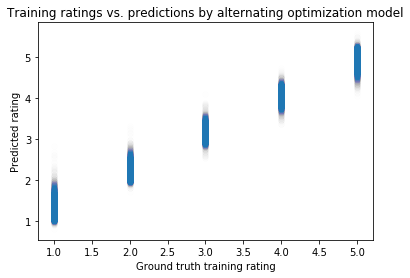

In [95]:
M_pred = Q_a.dot(P_a) + user_means # retrieve original values by adding the user mean
tuple_x = sp.find(M_train)
plt.scatter(x=tuple_x[2], y=np.array(M_pred[tuple_x[0],tuple_x[1]]), alpha=0.003)

plt.title('Training ratings vs. predictions by alternating optimization model')
plt.xlabel('Ground truth training rating')
plt.ylabel('Predicted rating')

plt.show()

## Predicted ratings vs. ground truth ratings (Gradient descent)

### Training data

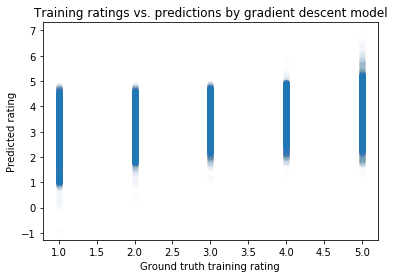

In [102]:
M_pred = best_Q_gr.dot(best_P_gr) + user_means # retrieve original values by adding the user mean
tuple_x = sp.find(M_train)
plt.scatter(x=tuple_x[2], y=np.array(M_pred[tuple_x[0],tuple_x[1]]), alpha=0.01)

plt.title('Training ratings vs. predictions by gradient descent model')
plt.xlabel('Ground truth training rating')
plt.ylabel('Predicted rating')

plt.show()

### Test data

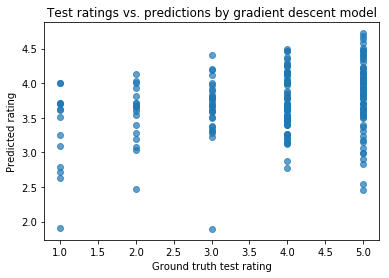

In [105]:
M_pred = best_Q_gr.dot(best_P_gr) + user_means # retrieve original values by adding the user mean

plt.scatter(x=test_values, y=np.array(M_pred[test_idx[0], test_idx[1]]), alpha=0.7)
plt.title('Test ratings vs. predictions by gradient descent model')
plt.xlabel('Ground truth test rating')
plt.ylabel('Predicted rating')

plt.show()